# Benchmark for Clustering

In [1]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import extract_labels_from_communities, time_tester, calculate_scores_clustering

from LocalStable import locally_stable_clustering_with_euclid_graphs

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_pos_labels

from PlotHelperFunctions import plot_and_save,normalize_score_column

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity



## Create Graphs

In [2]:
# Moon Dataset
moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)

# Circle Dataset
circle_agents, circle_truth = my_make_circles(300)

# Cancer Dataset
cancer = load_breast_cancer()
cancer_agents = cancer['data']
cancer_truth = cancer['target']

# Iris Dataset
iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']

## Run the algorithms


In [3]:
import itertools
import timeit

import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   

        data = [ moon_agents,circle_agents,cancer_agents,iris_agents]
        expected_clusters = [2,3,2,3]
        graph_names = ['Moons','3 Circles', 'Cancer', 'Iris']
        graph_truths =  [moon_truth,circle_truth,cancer_truth,iris_truth]
        
        
        kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
        dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)
        
        kmeans_out = None
        dbscan_out = None
        
        lp_a_b =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,allow_exit,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, allow_exit, mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, allow_exit, mode='E',pre=pre)
        
        algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'kmeans', 'dbscan','LS (Balanced) Heuristic',\
                       'LS (Friend-Oriented) Heuristic','LS (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
       

        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):

            graph,truth = randomize_graph_pos_labels(graph,truth)

            graph = [graph]
            truth = [truth]
                
            agents = graph
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,len(agents[0]),None,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with random clustering 
        
                a_name_modified = a_name + ' starting with predicted number of clusters'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,None,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
        
                # start with the output of k-means
                a_name_modified = a_name + ' starting with the output of k-means'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,kmeans,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time

                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with the output of dbscan
                a_name_modified = a_name + ' starting with the output of dbscan'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,dbscan,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                   
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))

            
            else:
        
                print(f"Running {a_name} on {g_name} … ", end='')
                test_callable = lambda a : algo(a, clusters)
                    
                times,outputs = time_tester(test_callable,graph)
                if(algo == kmeans):
                    kmeans_out = outputs
                if(algo == dbscan):
                    dbscan_out = outputs
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
                
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))

    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs[0].head()


Running kmeans on Moons … execution time: ~ 0.104650 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.48679565579268275
Davies Bouldin Score : ~ 0.7842736939308604
Time : ~ 0.10465009999461472
Running dbscan on Moons … execution time: ~ 0.002296 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3300330886149135
Davies Bouldin Score : ~ 1.165971337521373
Time : ~ 0.0022957000182941556
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 3.461467 seconds.
Rand Index : ~ 0.6410479375696767
Silhouette Score : ~ 0.5080574412371578
Davies Bouldin Score : ~ 0.6020465232721324
Time : ~ 3.4614666999550536
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.346706 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.3805556216682727
Davies Bouldin Score : ~ 1.0171035569709275
Time : ~ 0.3467056000372395
Running LS (Balanced) Heuristic starting with the output of k-means on Mo

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering
0,kmeans,Moons,"(0.6305239687848383, 0.0)","(0.48679565579268275, 0.0)","(0.7842736939308604, 0.0)","(0.10465009999461472, 0.0)",NaN
1,dbscan,Moons,"(1.0, 0.0)","(0.3300330886149135, 0.0)","(1.165971337521373, 0.0)","(0.0022957000182941556, 0.0)",NaN
2,LS (Balanced) Heuristic starting with everyone...,Moons,"(0.6410479375696767, 0.0)","(0.5080574412371578, 0.0)","(0.6020465232721324, 0.0)","(3.4614666999550536, 0.0)",NaN
3,LS (Balanced) Heuristic starting with predicte...,Moons,"(0.9168115942028986, 0.0)","(0.3805556216682727, 0.0)","(1.0171035569709275, 0.0)","(0.3467056000372395, 0.0)",NaN
4,LS (Balanced) Heuristic starting with the outp...,Moons,"(0.6339799331103679, 0.0)","(0.487225542711692, 0.0)","(0.784093083135743, 0.0)","(0.29539480002131313, 0.0)","(0.4994202898550725, 0.0)"


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [4]:
max_stds = {}

for df in dfs:
    for col in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

print(max_stds)

{'Rand Index': np.float64(0.0), 'Silhouette Score': np.float64(0.0), 'Davies Bouldin Score': np.float64(0.0)}


Figure saved as ./figures/StableClustering/Cancer-Rand Index.png


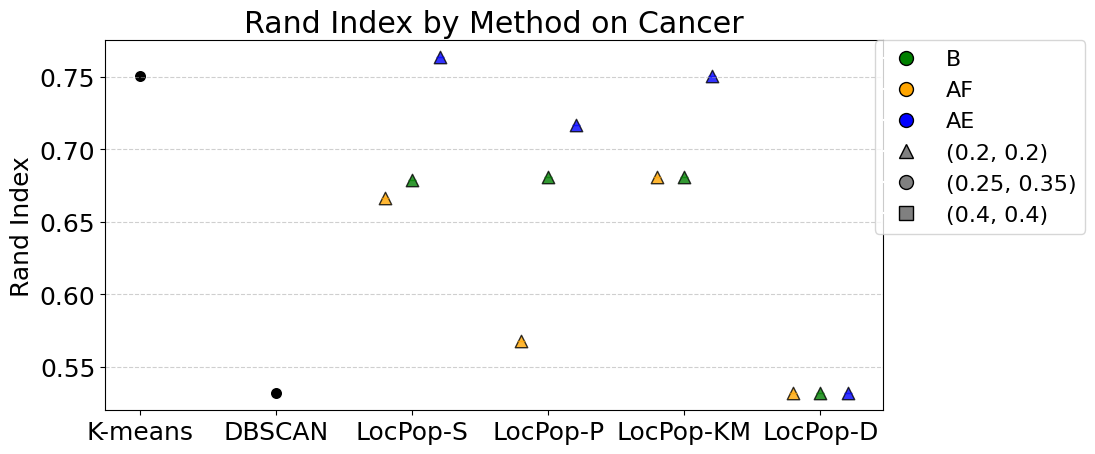

Figure saved as ./figures/StableClustering/Cancer-Silhouette Score.png


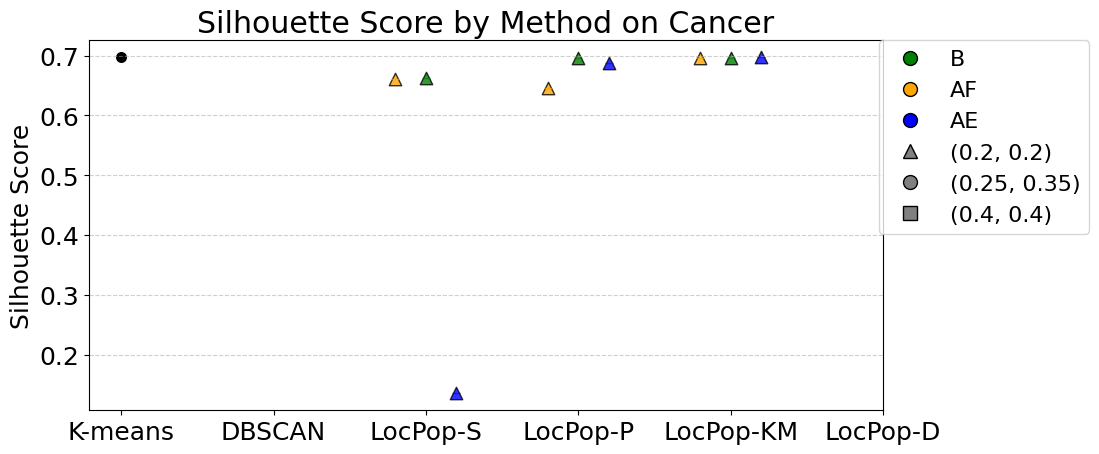

Figure saved as ./figures/StableClustering/Iris-Rand Index.png


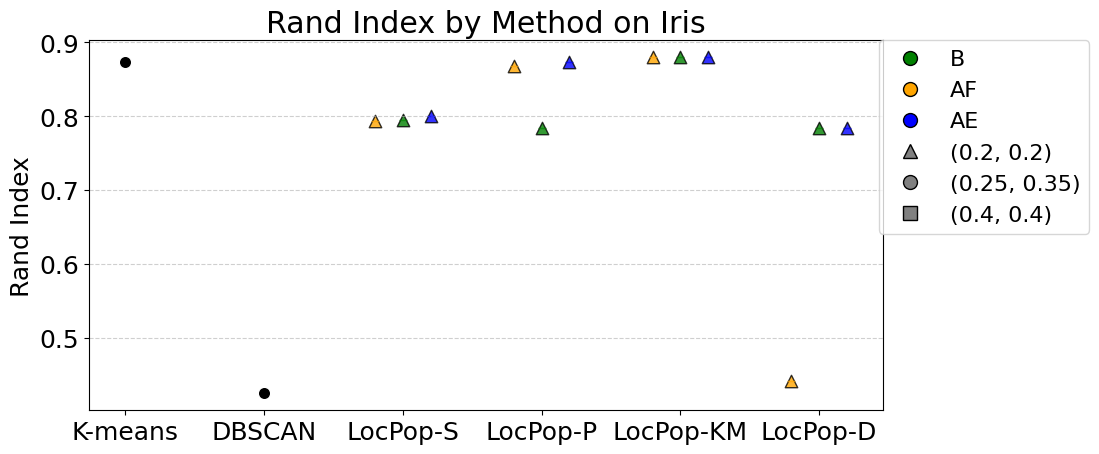

Figure saved as ./figures/StableClustering/Iris-Silhouette Score.png


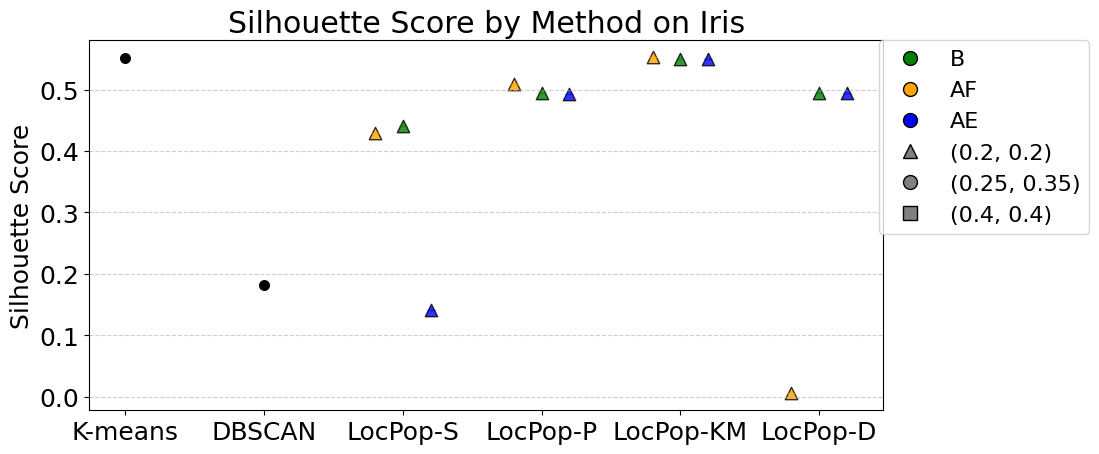

Figure saved as ./figures/StableClustering/Moons-Rand Index.png


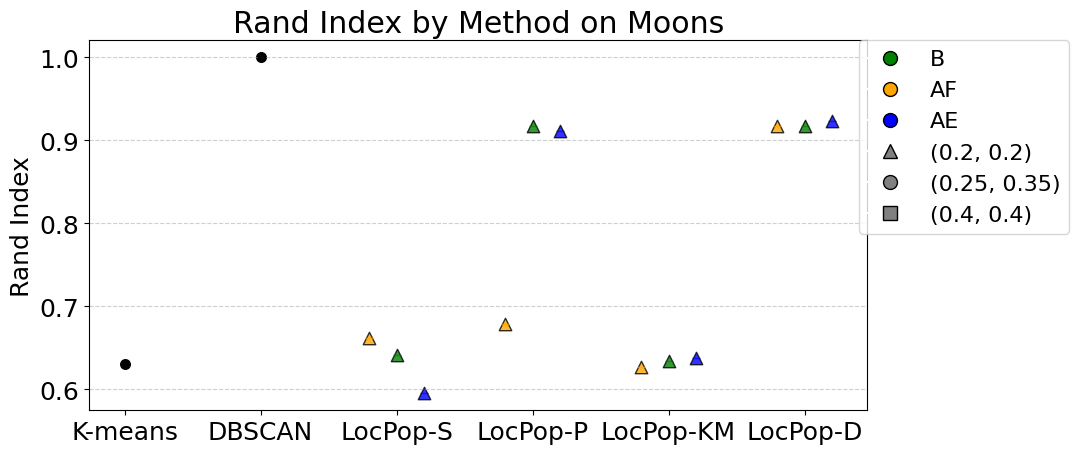

Figure saved as ./figures/StableClustering/Moons-Silhouette Score.png


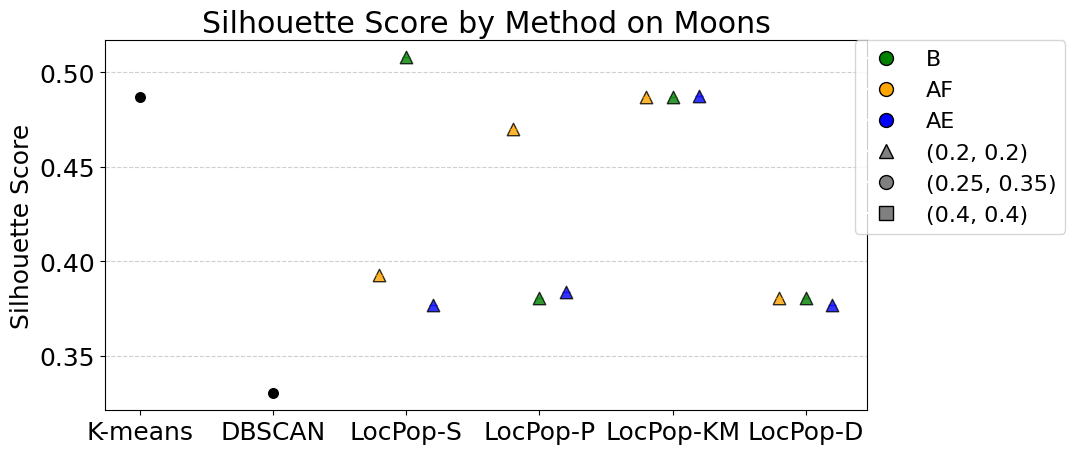

Figure saved as ./figures/StableClustering/3 Circles-Rand Index.png


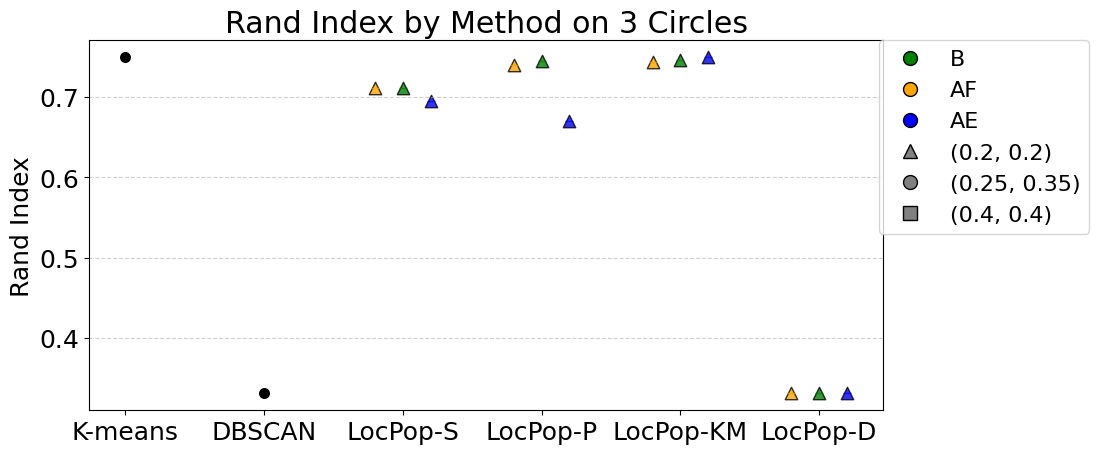

Figure saved as ./figures/StableClustering/3 Circles-Silhouette Score.png


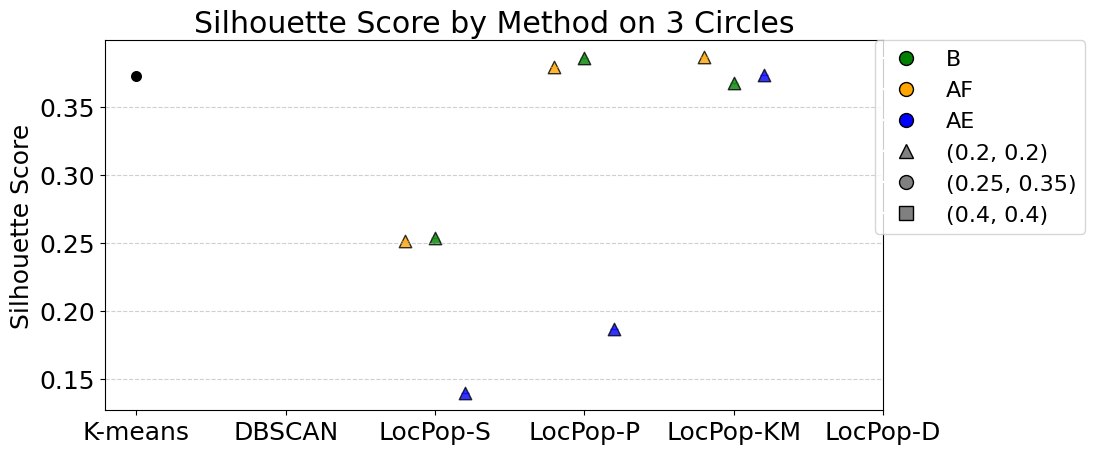

In [6]:
for df in dfs:
    df.replace("n.A.", np.nan, inplace=True)
    df.replace("My 3 Circles", "3 Circles", inplace = True)

score_cols = ['Rand Index', 'Silhouette Score']
dfs = [normalize_score_column(df, score_cols) for df in dfs]
labels = [(0.2,0.2),(0.25,0.35),(0.4,.4)]
# Then call your plotting
for Dataset in ['Cancer', 'Iris', 'Moons', '3 Circles']:
    for score in score_cols:
        plot_and_save(
            dfs, labels, Dataset, score,
            save_path=f'./figures/StableClustering/{Dataset}-{score}.png'
        )

In [9]:
dfs[0]

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering,Threshold
0,kmeans,Moons,"(0.6305239687848383, 0.0)","(0.48679565579268275, 0.0)","(0.7842736939308604, 0.0)","(0.10465009999461472, 0.0)",NaN,"(0.2, 0.2)"
1,dbscan,Moons,"(1.0, 0.0)","(0.3300330886149135, 0.0)","(1.165971337521373, 0.0)","(0.0022957000182941556, 0.0)",NaN,"(0.2, 0.2)"
2,LS (Balanced) Heuristic starting with everyone...,Moons,"(0.6410479375696767, 0.0)","(0.5080574412371578, 0.0)","(0.6020465232721324, 0.0)","(3.4614666999550536, 0.0)",NaN,"(0.2, 0.2)"
3,LS (Balanced) Heuristic starting with predicte...,Moons,"(0.9168115942028986, 0.0)","(0.3805556216682727, 0.0)","(1.0171035569709275, 0.0)","(0.3467056000372395, 0.0)",NaN,"(0.2, 0.2)"
4,LS (Balanced) Heuristic starting with the outp...,Moons,"(0.6339799331103679, 0.0)","(0.487225542711692, 0.0)","(0.784093083135743, 0.0)","(0.29539480002131313, 0.0)","(0.4994202898550725, 0.0)","(0.2, 0.2)"
5,LS (Balanced) Heuristic starting with the outp...,Moons,"(0.9168115942028986, 0.0)","(0.3805556216682727, 0.0)","(1.0171035569709275, 0.0)","(0.2777172001078725, 0.0)","(0.4983500557413601, 0.0)","(0.2, 0.2)"
6,LS (Friend-Oriented) Heuristic starting with e...,Moons,"(0.6615384615384615, 0.0)","(0.3925210492280343, 0.0)","(0.6010242044558414, 0.0)","(3.862016199971549, 0.0)",NaN,"(0.2, 0.2)"
7,LS (Friend-Oriented) Heuristic starting with p...,Moons,"(0.6789297658862876, 0.0)","(0.470167510793358, 0.0)","(0.7997989166301502, 0.0)","(0.2932336999801919, 0.0)",NaN,"(0.2, 0.2)"
8,LS (Friend-Oriented) Heuristic starting with t...,Moons,"(0.6271125975473801, 0.0)","(0.48691640679297366, 0.0)","(0.7837836689249895, 0.0)","(0.2976526999846101, 0.0)","(0.5001337792642141, 0.0)","(0.2, 0.2)"
9,LS (Friend-Oriented) Heuristic starting with t...,Moons,"(0.9168115942028986, 0.0)","(0.3805556216682728, 0.0)","(1.0171035569709281, 0.0)","(0.27932950004469603, 0.0)","(0.4983500557413601, 0.0)","(0.2, 0.2)"


In [7]:
import ast
import numpy as np
import pandas as pd

# Example: dfs = [df1, df2, df3]

all_values = []

for df in dfs:
    col = 'Rand Score with initial clustering'
    if col in df.columns:
        values = df[col].apply(
            lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('(')
            else x[0] if isinstance(x, (tuple, list))
            else float('nan')
        )
        all_values.extend(values.dropna().tolist())

# Convert to numpy array for convenience
all_values = np.array(all_values)

# Compute min, max, and average, ignoring NaNs
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
avg_val = np.nanmean(all_values)

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Average: {avg_val}")


Min: 0.4344519015659955
Max: 1.0
Average: 0.6448442513247551


In [8]:
for i,df in enumerate(dfs):
    df.to_csv(f'./csv/StableClustering/dataset-{i}.csv')